In [1]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tensorboard_logger import configure, log_value
from model import RecurrentAttention
from torchvision import transforms
from torchvision import datasets
import torch.nn.functional as F
import matplotlib.pyplot as plt
from utils import AverageMeter
from config import get_config
from utils import plot_images
from trainer import Trainer
from tqdm import tqdm
import pandas as pd
import torchvision
import numpy as np
import random
import pickle
import shutil
import torch
import time

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

from utils import *

In [2]:
m = open("../../pooling/data/migration_data.json",)
mig_data = json.load(m)
m.close()
mig_data = pd.DataFrame.from_dict(mig_data, orient = 'index').reset_index()
mig_data.columns = ['muni_id', 'num_migrants']
q = 4
mig_data['class'] = pd.qcut(mig_data['num_migrants'], q = q, labels = [i for i in range(q)])
mig_data.head()

,muni_id,num_migrants,class
0,484001001,42055.0,3
1,484001002,4017.0,3
2,484001003,11992.0,3
3,484001004,762.0,2
4,484001005,7551.0,3


In [3]:
image_names = get_png_names("../../attn/data/MEX/")

with open("../val_images.txt") as ims:
    val_names = ims.read().splitlines()
    
train_names = [i for i in image_names if i not in val_names]

In [4]:
y_class, y_mig = get_ys(image_names, mig_data)

In [5]:
train_num = int(25 * .70)
train_indices = random.sample(range(0, 25), train_num)
val_indices = [i for i in range(0, 25) if i not in train_indices]

In [6]:
batch_size = 1
train = [(torchvision.transforms.functional.adjust_brightness(load_inputs(image_names[i]), brightness_factor = 2).squeeze(), y_class[i], y_mig[i]) for i in train_indices]
val = [(torchvision.transforms.functional.adjust_brightness(load_inputs(image_names[i]), brightness_factor = 2).squeeze(), y_class[i], y_mig[i]) for i in val_indices]
train_dl = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = True)
val_dl = torch.utils.data.DataLoader(val, batch_size = batch_size, shuffle = True)

In [7]:
print("Num training: ", len(train_dl))
print("Num validation: ", len(val_dl))

Num training:  17
Num validation:  8


In [8]:
import numpy as np
from utils import plot_images

import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [9]:
config, unparsed = get_config()

In [10]:
trainer = Trainer(config, (train_dl, val_dl))

In [11]:
checkpoint = torch.load("./ckpt/ram_4_50x50_0.75_model_best.pth.tar")
checkpoint = checkpoint["model_state"]

In [ ]:
trues, preds, classes, tv = [], [], [], []

for im in val_names:
        
    i = load_inputs(im)
    o = torch.tensor(mig_data[mig_data["muni_id"] == im.split("/")[5]]['class'].values[0])
    o2 = torch.tensor(mig_data[mig_data["muni_id"] == im.split("/")[5]]['num_migrants'].values[0])
    
    pred = trainer.predict(1, i, o, o2, checkpoint).item()
    true = o2.item()
    
    trues.append(true)
    preds.append(pred)
    classes.append(o.item())
    tv.append('val')
    
for im in train_names:
        
    i = load_inputs(im)
    o = torch.tensor(mig_data[mig_data["muni_id"] == im.split("/")[5]]['class'].values[0])
    o2 = torch.tensor(mig_data[mig_data["muni_id"] == im.split("/")[5]]['num_migrants'].values[0])
    
    pred = trainer.predict(1, i, o, o2, checkpoint).item()
    true = o2.item()
    
    trues.append(true)
    preds.append(pred)
    classes.append(o.item())
    tv.append('train')    
    
    
preds_df = pd.DataFrame()
preds_df['true'], preds_df['pred'], preds_df['class'] = trues, preds, classes
preds_df.head()

In [40]:
preds_df['tv'] = tv

Text(0, 0.5, 'True')

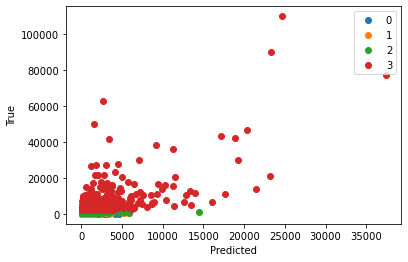

In [41]:
groups = preds_df.groupby("class")
for name, group in groups:
    plt.plot(group["pred"], group["true"], marker="o", linestyle="", label=name)
plt.legend()
plt.xlabel("Predicted")
plt.ylabel("True")

In [42]:
preds_df.to_csv("./4_locs_std4_noLSTM_preds_v2.csv")

Text(0, 0.5, 'True')

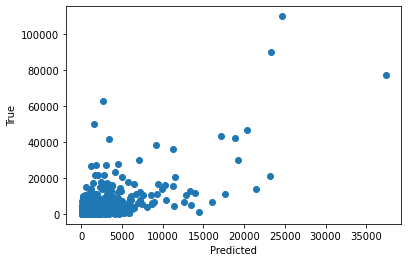

In [43]:
plt.scatter(preds_df['pred'], preds_df['true'])
plt.xlabel("Predicted")
plt.ylabel("True")

In [44]:
for name, group in groups:
    print(name, np.mean(abs(group["true"] - group["pred"])))

0 357.2152425485064
1 416.1141617467084
2 681.8326576508497
3 3995.7584820163343


In [45]:
preds_df

,true,pred,class,tv
0,1446.0,1098.010620,2,val
1,25.0,1475.329834,0,val
2,7551.0,3202.572266,3,val
3,988.0,1474.625000,2,val
4,7444.0,2062.379639,3,val
...,...,...,...,...
2061,1551.0,716.035034,2,train
2062,717.0,802.367676,2,train
2063,2487.0,1757.851807,3,train
2064,2024.0,1105.130371,3,train


In [46]:
import sklearn.metrics

sklearn.metrics.r2_score(preds_df['true'], preds_df['pred'])

0.37481305739182746